# Text Mining using Dimensionality Reduction Methods

Using a dataset from the Internet Movie Database consisting of 1000 reviews labelled as positive or negative by humans, I will use dimensionality reduction techniques in order to analyse and predict sentiment in a set of texts. The data include a set of text and a binary label (positive or negative).


In [1]:
# Import other packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [3]:
#import the data
imdb_data = pd.read_excel('IMDB_Sample.xlsx')

#define a transformer
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.95, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf=True # Use sublinear weights (softplus)
                      )

# Train / test split
x_train, x_test, y_train, y_test = train_test_split(imdb_data['texts'],
                                                    imdb_data['class'],
                                                    test_size=0.3,
                                                    random_state=20210318)

# Calculate the Tf-Idf transform.
TfIDF_train = TfIDFTransformer.fit_transform(x_train)
TfIDF_test = TfIDFTransformer.transform(x_test)

# Turn to dense matrix as PCA does not like sparse ones.
TfIDF_train = TfIDF_train.toarray()
TfIDF_test = TfIDF_test.toarray()

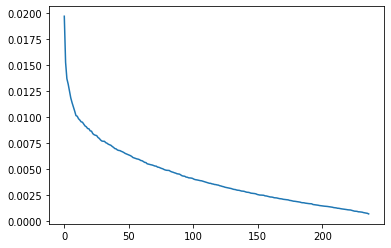

In [4]:
#Explore commonly-occuring concepts by performing Partial Component Analysis (PCA) on the data
# the maximum number of concepts is the number of words ie 236
import sklearn.decomposition as skd
PCA=skd.PCA()
Z_train=PCA.fit_transform(TfIDF_train)
exp_var1=PCA.explained_variance_ratio_ # this is a vector holding the explained variance for each of the components

# Make the plot
comps=np.linspace(0,236, 236) # make the x values to be plotted
plt.plot(comps, exp_var1)
plt.show()

In [10]:
# To get the exact index where the variance is above 75%
# print(len(comps))
#the sum of all the variance ratios equals 1; we want to just find out the index of the component
#which represents the stopping point, before which 75% of the data is explained.
total=0 #will keep a total of the sum of variance from each component
idx=0 #stores each of the indices as they are iterated over
for i in range(236):
    total+=exp_var1[i]
    idx=i #keep track of the current index
    if total>=0.75:
        break #break out of the loop once 75% total variance is reached

print(idx)
    
    

113


In [14]:
# Explained variance.
#start by acessing the components, they are already ordered by decreasing importance
components=PCA.components_
#grab the top three
topThree=components[:3,:]
#now sum each of their explained variances
topThreeVariance=sum(exp_var1[:3])
print(topThreeVariance) ##this is the variance explained by the top three concepts


0.04860463896012033

In [19]:
# Get words per component
masterList=TfIDFTransformer.get_feature_names() #this is a list of all of the words
#iterate over each of the top three concepts (ie over each row) and find the top 10 words ()
#store the index of the words in the column in order to access the actual words from the master list later
indices=[0,0,0] #will be a list of three lists, each holding the indices of the top 10 words in each concept
for i in range(3):
    features=topThree[i,:].reshape(-1,)
    topIdx=np.argsort(features)[-10:] #argsort sorts the items in the iterable in decreasing order and returns the corresponding indices of the original iterable
    indices[i]=topIdx

In [21]:
# Concept 1
words1=[] #an empty list to hold the words
for i in indices[0]:
    words1.append(masterList[i])
print(words1)

['thought', 'just', 'terrible', 'think', 'don', 'watch', 'like', 'movies', 'bad', 'movie']


In [22]:
# Concept 2
words2=[] #an empty list to hold the words
for i in indices[1]:
    words2.append(masterList[i])
print(words2)

['movies', 'cast', 'loved', 'excellent', 'characters', 'john', 'love', 'story', 'great', 'series']


In [23]:
# Concept 3
words3=[] #an empty list to hold the words
for i in indices[0]:
    words3.append(masterList[i])
print(words3)

['thought', 'just', 'terrible', 'think', 'don', 'watch', 'like', 'movies', 'bad', 'movie']


(2, 236)


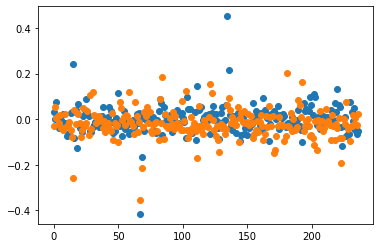

In [5]:
# Apply the test data
Z=PCA.transform(TfIDF_test)
ZfirstTwo=PCA.components_[:2,:]
print(ZfirstTwo.shape)
# Plot the two different set of points filtering by label.
plt.scatter(comps, ZfirstTwo[0,:], label="component 1")
plt.scatter(comps, ZfirstTwo[1,:], label="component 2")
plt.show()

Just based on this plot it is hard to distinguish between which points were assigned positive and negative labels, as they all seem to be relatively equivalently distributed about 0.

In [6]:
#now explore the ability of encoding and de-coding of autoencoders; use a grid search to tune to the optimal architecture
class autoencoder1(nn.Module):
    def __init__(self):
        super(autoencoder1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(236,100),
            nn.ReLU(),
            nn.Linear(100,60),
            nn.ReLU(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(60,100),
            nn.ReLU(),
            nn.Linear(100, 236),
            nn.ReLU(),
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
autoencoder1=autoencoder1()
loss_fn=torch.nn.MSELoss()
learning_rate=0.1

In [7]:
# Train
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_scaled=scaler.fit_transform(TfIDF_train)
X_scaled=X_scaled.astype(np.float32)
X_scaled=torch.from_numpy(X_scaled)#convert the data set to tensors

#now actually train the model
loss_encoder1=[] # a container to hold the losses for the first encoder
epochs1=[] # a container to hold the number of epochs explored for this first encoder
for i in range(10000):
    y_pred=autoencoder1(X_scaled)
    loss=loss_fn(y_pred,X_scaled) # this is the error btw the original and reconstructed data
    if i%100==99: #only storing every 100 rounds
        loss_encoder1.append(loss.item())
        epochs1.append(i)
    autoencoder1.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in autoencoder1.parameters():
            param-=learning_rate*param.grad
        
        

KeyboardInterrupt: 

In [ ]:
# Plot errors
plt.plot(epochs1, loss_encoder1)
plt.show()

In [ ]:
#now compare the performance of a logistic regression model over the original TfIDF data set, the PCA-reduced data set, and the encoded data set; visualize performance using ROC curves

0.859


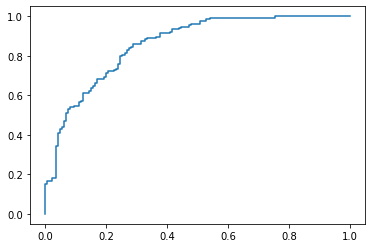

In [50]:
# Full dataset regression and AUC plot / calculation
model1=LogisticRegressionCV(cv=5, max_iter=1000).fit(TfIDF_train, y_train)
y_pred=model1.predict(TfIDF_test)
y_pred_proba=model1.predict_proba(TfIDF_test)
fpr, tpr, _=roc_curve(y_test, y_pred_proba[:,1], pos_label=1)
auc = np.round(roc_auc_score(y_true = y_test, y_score = y_pred_proba[:,1]),decimals = 3)
print(auc)
#now plot the ROC curve
plt.plot(fpr, tpr)
plt.show()

0.7353228962818004


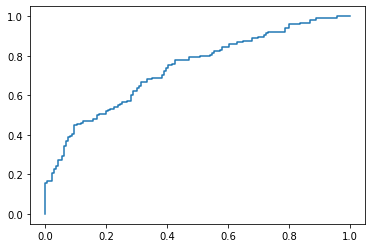

In [57]:
# PCA dataset regression and AUC plot / calculation
PCA=skd.PCA(n_components=60)
x_train_pca=PCA.fit_transform(TfIDF_train)
x_test_pca=PCA.fit_transform(TfIDF_test)
LogReg=LogisticRegressionCV(cv=5, max_iter=1000).fit(x_train_pca, y_train)
y_pred_probs_pca=LogReg.predict_proba(x_test_pca)
fpr, tpr,_=roc_curve(y_test,y_pred_probs_pca[:,1])
auc2=roc_auc_score(y_test, y_pred_probs_pca[:,1])
print(auc2)
plt.plot(fpr, tpr)
plt.show()


In [63]:
# Autoencoder dataset regression and AUC plot / calculation
x_train_encoded=autoencoder1.encoder(torch.from_numpy(TfIDF_train).float()).detach().numpy()
x_test_encoded=autoencoder1.encoder(torch.from_numpy(TfIDF_test).float()).detach().numpy()
LogReg=LogisticRegressionCV(cv=5, max_iter=1000).fit(x_train_encoded, y_train)
y_pred_probs_encoded=LogReg.predict_proba(x_test_encoded)
fpr, tpr,_=roc_curve(y_test, y_pred_probs_encoded[:,1])
auc3=roc_auc_score